In [1]:
import numpy as np
import pandas as pd
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
import category_encoders as ce 
import warnings
warnings.filterwarnings('ignore')

In [2]:
nlp = spacy.load('es_core_news_sm', disable=['ner','parser'])

In [3]:
train = pd.read_csv("train_con_zona.csv", parse_dates=['fecha'])
val = pd.read_csv("test_con_zona.csv", parse_dates=['fecha'])

In [4]:
class TituloDescripcionConcat( BaseEstimator, TransformerMixin ):
    '''
    Se concatena la columna texto con la columna descripccion en una nueva columna llamada "text"
    '''
    def __init__( self ):
        pass
      
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        X.descripcion = X.descripcion.fillna(" ")
        X.titulo = X.titulo.fillna(" ")
        X["text"] = X["titulo"] + " " + X["descripcion"]
        X = X[["text"]]
        return X

In [5]:
class HtmlCleaner( BaseEstimator, TransformerMixin ):
    '''
    Se limpia todo el html que hay en la columna text
    '''
    def __init__( self ):
        pass
    
    def clean_html(self,raw_html):
        soup = BeautifulSoup(raw_html)
        text = soup.get_text()
        return text
      
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        X.text = [self.clean_html(text) for text in X.text]
        return X

In [6]:
import string
class TextCleaner( BaseEstimator, TransformerMixin ):
    '''
    Se limpian stopwords, numeros, puntuaciones y se convierten las palabras a raiz
    '''
    def __init__( self ):
        pass
    
    def cleanup_text(self, doc):
        txt = [token.lemma_ for token in doc if not token.is_stop]
        return ' '.join(txt)
        
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        brief_cleaning = (re.sub("[^A-Za-z']+",' ', str(row)).lower() for row in X['text'])
        txt = [self.cleanup_text(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads = -1)]
        X = pd.DataFrame({'text':txt})
        return X.text

In [7]:
#Iterative imputer en los valores faltantes
class MissingValuesImputer( BaseEstimator, TransformerMixin ):
      
    def __init__( self, features_to_impute ):
        self._features_to_impute = features_to_impute
        
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        imp = IterativeImputer(missing_values=np.nan, max_iter=30, random_state=42)
        X[features_to_impute] = imp.fit_transform(X[features_to_impute])
        return X

In [8]:
# Dropear columnas que no se usan
class DropFeatures( BaseEstimator, TransformerMixin ):
    
    def __init__( self, features_to_drop ):
        self._features_to_drop = features_to_drop 
      
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        for feat in self._features_to_drop:
            if feat in X.columns:
                X = X.drop(feat, axis=1)
        return X

In [9]:
#Encoder para las categorias
class CategoryEncoder( BaseEstimator, TransformerMixin ):
      
    def fit( self, X, y = None ):
        self.ciudad_te = ce.TargetEncoder().fit(X['ciudad'], X['precio'])
        self.tipo_te = ce.TargetEncoder().fit(X['tipodepropiedad'], X['precio'])
        self.prov_te = ce.TargetEncoder().fit(X['provincia'], X['precio'])
        self.zona_te = ce.TargetEncoder().fit(X['zona'], X['precio'])
        return self 
    
    def transform( self, X, y = None ):
        X['ciudad'] = self.ciudad_te.transform(X['ciudad'])
        X['tipodepropiedad'] = self.tipo_te.transform(X['tipodepropiedad'])
        X['provincia'] = self.prov_te.transform(X['provincia'])
        X['zona'] = self.zona_te.transform(X['zona'])
        return X

In [10]:
#Tomo el año de las fechas
class DateTransformer( BaseEstimator, TransformerMixin ):
      
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        X['ano'] = X.fecha.dt.year
        X = X.drop('fecha',axis=1)
        return X

In [11]:
features_to_drop = ['lat','lng','direccion','idzona','id','titulo','descripcion','text','centroscomercialescercanos','escuelascercanas']

features_to_impute = ['gimnasio', 'usosmultiples', 'piscina', 'tipodepropiedad','ciudad','provincia',
                      'habitaciones','garages','banos','metroscubiertos','ano','metrostotales','antiguedad']

text_preprocessing_pipeline = Pipeline( steps =   [ ('concat_titulo_descripcion',TituloDescripcionConcat()),
                                                    ('clean_html',HtmlCleaner()),
                                                    ('clean_text',TextCleaner()),
                                                    ('bow', CountVectorizer(max_features = 800)),
                                                    ('tfidf', TfidfTransformer()),
                                                    ('reduce_dim',TruncatedSVD(n_components=20))
                                                  ])

features_preprocessing_pipeline = Pipeline( steps =   [ ('drop', DropFeatures(features_to_drop)),
                                                        ('date_transformer',DateTransformer()),
                                                        ('category_encoder',CategoryEncoder()),
                                                        ('drop_target', DropFeatures(['precio'])),
                                                        ('missing_values_imputer',MissingValuesImputer(features_to_impute)),
                                                        ('scale', StandardScaler())
                                                       ] )

preprocessing = FeatureUnion([('generate_text_features',text_preprocessing_pipeline),
                                ('preprocess_features', features_preprocessing_pipeline)
                               ])

En este pruebo Agregar tipo de zona (urbano/etc)

In [12]:
train_df , test_df = train_test_split(train, test_size=0.2)

In [13]:
y_train = train_df.precio
y_test = test_df.precio

In [14]:
%%time
X_train = preprocessing.fit_transform(train_df)

Wall time: 9min 29s


In [15]:
%%time
X_test = preprocessing.transform(test_df)

Wall time: 2min 20s


In [16]:
%%time
val_prep = preprocessing.transform(val)

Wall time: 2min 55s


# Modelos

## XGB

In [17]:
%%time
xgbr = xgb.XGBRegressor(learning_rate=0.03,max_depth=8, n_estimators=1000, n_jobs=-1, objective ='reg:squarederror')
xgbr.fit(X_train,y_train)
xgbr_test_pred = xgbr.predict(X_test)
xgbr_train_pred = xgbr.predict(X_train)

Wall time: 6min 57s


In [18]:
mean_absolute_error(y_test,xgbr_test_pred)

568064.131303711

In [19]:
mean_absolute_error(y_train,xgbr_train_pred)

455250.89979740395

In [20]:
subm_preds = xgbr.predict(val_prep)
subm = pd.DataFrame({'id':val.id, 'target':subm_preds})
subm.to_csv("Xgbr_subm.csv", index=False)

# NN

In [21]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from keras import optimizers
import keras

Using TensorFlow backend.


In [22]:
model = Sequential()
model.add(Dropout(0.2, input_shape=(X_train.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(1,))

In [23]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(adam, 'mean_absolute_error')

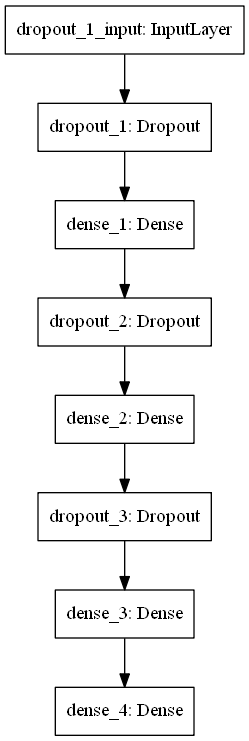

In [24]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [25]:
%%time
model.fit(X_train, y_train, 
          batch_size= 512, 
          epochs = 100, 
          validation_data=(X_test, y_test),
          callbacks=[keras.callbacks.EarlyStopping(patience=6)])

Train on 192000 samples, validate on 48000 samples
Epoch 1/100
192000/192000 [==============================] - 16s 83us/step - loss: 1686410.1128 - val_loss: 808432.6980
Epoch 2/100
192000/192000 [==============================] - 14s 72us/step - loss: 867495.2048 - val_loss: 747498.0127
Epoch 3/100
192000/192000 [==============================] - 13s 70us/step - loss: 841042.9872 - val_loss: 731905.4665
Epoch 4/100
192000/192000 [==============================] - 14s 73us/step - loss: 829233.8825 - val_loss: 723683.2633
Epoch 5/100
192000/192000 [==============================] - 14s 75us/step - loss: 823669.9627 - val_loss: 719071.8558
Epoch 6/100
192000/192000 [==============================] - 13s 65us/step - loss: 819175.4542 - val_loss: 714056.9862
Epoch 7/100
192000/192000 [==============================] - 14s 75us/step - loss: 815449.7467 - val_loss: 710783.3935
Epoch 8/100
192000/192000 [==============================] - 16s 82us/step - loss: 812155.6550 - val_loss: 711081.9

In [26]:
subm_preds = model.predict(val_prep).ravel()
subm = pd.DataFrame({'id':val.id, 'target':subm_preds.ravel()})
subm.to_csv("NN_subm.csv", index=False)

## Random forest

In [27]:
from skl earn.ensemble import RandomForestRegressor

SyntaxError: invalid syntax (<ipython-input-27-89281e643169>, line 1)

In [ ]:
%%time
random_forest = RandomForestRegressor(max_depth=20, n_estimators=1000, min_samples_leaf=20, n_jobs=-1)
random_forest.fit(X_train, y_train)
pred_train = random_forest.predict(X_train)
pred_test = random_forest.predict(X_test)

In [ ]:
print("Train "+str(mean_absolute_error(y_train, pred_train)))
print("Test "+str(mean_absolute_error(y_test, pred_test)))

In [ ]:
subm_preds = random_forest.predict(val_prep)
subm = pd.DataFrame({'id':val.id, 'target':subm_preds})
subm.to_csv("Rf_subm.csv", index=False)